READING AND PREPARING DATA

In [1]:
from dotenv import load_dotenv
import os

load_dotenv()
dirname = os.path.dirname(os.getenv('PATH_TO_DATABASE'))

In [2]:
import cv2

def load_images_from_folder(folder):
    images = []
    labels = []
    for foldername in os.listdir(folder):
        for filename in os.listdir(os.path.join(folder, foldername)):
            img = cv2.imread(os.path.join(folder, foldername, filename))
            if img is not None:
                images.append(img)
                labels.append(foldername)
    return images, labels

images, labels = load_images_from_folder(dirname)

In [157]:
images[60].shape

(3328, 4992, 3)

(<matplotlib.image.AxesImage at 0x1dae7936bf0>, 'downdog')

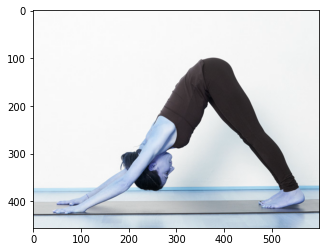

In [3]:
import matplotlib.pyplot as plt
plt.imshow(images[85]), labels[85]

In [4]:
import mediapipe as mp

mp_pose = mp.solutions.pose
pose_image = mp_pose.Pose(static_image_mode=True, min_detection_confidence=0.5)

In [5]:
def get_pose_arr(landmark_input):
    pose_only = landmark_input.pose_landmarks.landmark[10:-1]
    pose_arr = [[body_part.x, body_part.y, body_part.z, body_part.visibility] for body_part in pose_only]
    return pose_arr


In [6]:
def detect_pose(image_pose, pose=pose_image):  
    image_in_RGB = cv2.cvtColor(image_pose, cv2.COLOR_BGR2RGB)
    result = pose.process(image_in_RGB)
    return get_pose_arr(result)

In [7]:
pose_detected_images = []

for image in images:
    pose_detected_images.append(detect_pose(image))

In [8]:
import numpy as np
pose_detected_3d = np.asarray(pose_detected_images)
pose_detected_3d.shape, len(labels)

((375, 22, 4), 375)

In [9]:
pose_detected_3d[0]

array([[ 0.510221  ,  0.69683099, -0.0243786 ,  0.99854088],
       [ 0.45331055,  0.60359496, -0.28181142,  0.99890161],
       [ 0.46180576,  0.59795725,  0.16249289,  0.99472284],
       [ 0.36895648,  0.78477967, -0.53599977,  0.99353623],
       [ 0.38082516,  0.75728786,  0.27287439,  0.1719849 ],
       [ 0.25563321,  0.92410576, -0.52789062,  0.97920942],
       [ 0.28789201,  0.86890554,  0.02526758,  0.39537483],
       [ 0.21926026,  0.93814093, -0.59312636,  0.96762186],
       [ 0.25090343,  0.88393027,  0.01692992,  0.58230227],
       [ 0.21637714,  0.92914724, -0.54370785,  0.96074128],
       [ 0.2462455 ,  0.88902336, -0.04811274,  0.59691572],
       [ 0.22786042,  0.92453223, -0.50951552,  0.94268978],
       [ 0.25871223,  0.88473135, -0.00628529,  0.59180844],
       [ 0.67124277,  0.25772136, -0.18266299,  0.99642307],
       [ 0.66190964,  0.26562071,  0.18328379,  0.99314547],
       [ 0.77518868,  0.53248739, -0.13557042,  0.97935379],
       [ 0.76589632,  0.

In [10]:
pose_detected_2d = np.reshape(pose_detected_3d, (len(labels), 88))

pose_detected_2d[0], pose_detected_2d.shape

(array([ 0.510221  ,  0.69683099, -0.0243786 ,  0.99854088,  0.45331055,
         0.60359496, -0.28181142,  0.99890161,  0.46180576,  0.59795725,
         0.16249289,  0.99472284,  0.36895648,  0.78477967, -0.53599977,
         0.99353623,  0.38082516,  0.75728786,  0.27287439,  0.1719849 ,
         0.25563321,  0.92410576, -0.52789062,  0.97920942,  0.28789201,
         0.86890554,  0.02526758,  0.39537483,  0.21926026,  0.93814093,
        -0.59312636,  0.96762186,  0.25090343,  0.88393027,  0.01692992,
         0.58230227,  0.21637714,  0.92914724, -0.54370785,  0.96074128,
         0.2462455 ,  0.88902336, -0.04811274,  0.59691572,  0.22786042,
         0.92453223, -0.50951552,  0.94268978,  0.25871223,  0.88473135,
        -0.00628529,  0.59180844,  0.67124277,  0.25772136, -0.18266299,
         0.99642307,  0.66190964,  0.26562071,  0.18328379,  0.99314547,
         0.77518868,  0.53248739, -0.13557042,  0.97935379,  0.76589632,
         0.54136729,  0.21249466,  0.21272953,  0.8

Classification

In [25]:
from sklearn import preprocessing

le = preprocessing.LabelEncoder()
le.fit(labels)

LabelEncoder()

In [148]:
X = pose_detected_2d
y = le.transform(labels)

In [149]:
from sklearn.model_selection import KFold


kfold = KFold(n_splits=5, shuffle=True, random_state=15)

In [150]:
from sklearn.svm import SVC

clf_SVC = SVC(C=1000)

In [151]:
from sklearn.ensemble import RandomForestClassifier

clf_RF = RandomForestClassifier(max_depth=8, random_state=0)

In [152]:
from sklearn.metrics import accuracy_score

y_shuffled = []
SVC_predictions = []
RF_predictions = []

for train_index, test_index in kfold.split(X):

    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    clf_SVC.fit(X_train, y_train)
    SVC_prediction = clf_SVC.predict(X_test)
    SVC_predictions = np.concatenate((SVC_predictions, SVC_prediction))


    clf_RF.fit(X_train, y_train)
    RF_prediction = clf_RF.predict(X_test)
    RF_predictions = np.concatenate((RF_predictions, RF_prediction))

    y_shuffled = np.concatenate((y_shuffled, y_test))

    print('Fold')
    print(f'SVC accuracy {accuracy_score(y_test, SVC_prediction)}')
    print(f'RF accuracy {accuracy_score(y_test, RF_prediction)}')


Fold
SVC accuracy 0.9866666666666667
RF accuracy 0.9733333333333334
Fold
SVC accuracy 0.9333333333333333
RF accuracy 0.9466666666666667
Fold
SVC accuracy 0.9866666666666667
RF accuracy 0.9866666666666667
Fold
SVC accuracy 0.9733333333333334
RF accuracy 0.9866666666666667
Fold
SVC accuracy 0.9733333333333334
RF accuracy 0.9866666666666667


In [153]:
SVC_accuracy = accuracy_score(y_shuffled, SVC_predictions)
RF_accuracy = accuracy_score(y_shuffled, RF_predictions)
SVC_accuracy, RF_accuracy

(0.9706666666666667, 0.976)

In [154]:
for x, y in zip(y_shuffled, SVC_predictions):
    if x != y:
        print(x, y)

3.0 2.0
0.0 4.0
1.0 3.0
2.0 1.0
2.0 0.0
4.0 1.0
1.0 4.0
3.0 1.0
4.0 1.0
0.0 2.0
1.0 4.0


In [155]:
for x, y in zip(y_shuffled, RF_predictions):
    if x != y:
        print(x, y)

1.0 4.0
1.0 4.0
0.0 3.0
1.0 4.0
1.0 3.0
2.0 0.0
1.0 4.0
1.0 4.0
1.0 4.0
